# Calculating RNBS
Lindsay Fitzpatrick
ljob@umich.edu
08/19/2024

This script uses the forecast data from CFS and runs it through the trained models to produce
an ensemble of RNBS forecasts for each of the Great Lakes. It saves the forecast values as a 
CSV and creates a timeseries plot that is saved as a PNG.

In [145]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib
import calendar

User Input

In [147]:
# Directory to downloaded/processed CFS data
dir = f'C:/Users/fitzpatrick/Desktop/Data/'

# Read in the CSVs
pcp_data = pd.read_csv(dir+f'2020/CFS_APCP_Basin_Sums.csv',sep=',')
tmp_data = pd.read_csv(dir+f'2020/CFS_TMP_Basin_Avgs.csv',sep=',')
evap_data = pd.read_csv(dir+f'2020/CFS_EVAP_Basin_Sums.csv',sep=',')

# Open the trained model(s)
# For the MVP we are only going to use the GP model since it has the best performance
GP_model = joblib.load('GP_trained_model.joblib')
LR_model = joblib.load('LR_trained_model.joblib')

FileNotFoundError: [Errno 2] No such file or directory: 'GP_trained_model.joblib'

Defined Functions

In [41]:
def calculate_cnbs(df, prefixes):
    """
    Calculate CNBS values based on the provided prefix.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the relevant data.
    prefix (str): The prefix for the relevant columns (e.g., 'su', 'er', 'on', 'mh').

    Returns:
    pd.DataFrame: The DataFrame with new CNBS columns added.
    """
    for prefix in prefixes:
        cnbs_column = f'{prefix}_cnbs'
        df[cnbs_column] = df[f'{prefix}_precip'] + df[f'{prefix}_runoff'] - df[f'{prefix}_evap']
        
    return df

In [ ]:
def seconds_in_month(year, month):
    # Number of days in the month
    num_days = calendar.monthrange(year, month)[1]
    # Convert days to seconds
    return num_days * 24 * 60 * 60

In [ ]:
def convert_cms_to_mm(df_cms):

    # Create a copy of the dataframe so we aren't altering the df_cms
    df_mm = df_cms.copy()

    sa_su = 82097*1000000
    sa_mh = (57753 + 5956)*1000000
    sa_er = 25655*1000000
    sa_on = 19009*1000000
    
    # Calculate the number of seconds for each month
    df_mm['seconds'] = df_mm.apply(lambda row: seconds_in_month(int(row['forecast_year']), int(row['forecast_month'])), axis=1)

    # value_cms / surface_area * seconds_in_a_month = m * 1000 = mm
    for column in df_mm.columns:
        if column.startswith("er"):
            df_mm[column] = df_mm[column] / sa_er * df_mm['seconds'] * 1000
        elif column.startswith("su"):
            df_mm[column] = df_mm[column] / sa_su * df_mm['seconds'] * 1000
        elif column.startswith("mh"):
            df_mm[column] = df_mm[column] / sa_mh * df_mm['seconds'] * 1000
        elif column.startswith("on"):
            df_mm[column] = df_mm[column] / sa_on * df_mm['seconds'] * 1000

    return df_mm

In [57]:
def filter_forecast_data(df):
    current_month = datetime.now().month
    current_year = datetime.now().year
    current_day = datetime.now().day

    if current_day >= 26:
        # Remove the current month and all previous months
        filtered_df = df[
            (df['forecast_year'] > current_year) |
            ((df['forecast_year'] == current_year) & (df['forecast_month'] > current_month))
        ]
    else:
        # Keep current month and all previous months
        filtered_df = df[
            (df['forecast_year'] > current_year) |
            ((df['forecast_year'] == current_year) & (df['forecast_month'] >= current_month))
        ]
    
    return filtered_df

In [67]:
def mean_min_max(df, lake):
    """
    Calculate mean, min, and max for a specific lake in the DataFrame.

    Parameters:
    - df: DataFrame containing the data.
    - lake: Column name to calculate statistics for.

    Returns:
    - A DataFrame containing mean, min, and max for each combination of forecast_year and forecast_month.
    """
    results =  df.groupby(['forecast_year', 'forecast_month'])[lake].agg(['mean', 'min', 'max']).reset_index()

    return results


In [ ]:
def create_plot():

    # Create a 4x4 grid of subplots
    fig, axs = plt.subplots(4, 4, figsize=(20, 10), sharex=True)
    axs = axs.flatten()
    
    row_labels = ['Lake Superior', 'Lake Mich-Huron', 'Lake Erie', 'Lake Ontario']
    column_labels = ['Precipitation [mm]', 'Evaporation [mm]', 'Runoff [mm]', 'CNBS [mm]']
    num_months = len(mean_mh_cnbs['forecast_month'])

    # Plot each dataset
    for i in range(0,16):
        #axs[i].plot(x_values, mean, color='red', marker='o', markersize = 1.5, linestyle='-', linewidth=1, label='GP Model')
        axs[i].axhline(y=0, color='black', linestyle='-', linewidth=1.2)
        #axs[i].fill_between(x_values, min_val, max_val, color='gray', alpha=0.2)
        axs[i].set_xlim(0, num_months-1)
        axs[i].grid(True, linestyle='--', alpha=0.6)
        
        if i == 3:
            axs[i].legend(loc='upper right')

        if i in [3, 7, 11, 15]:  # Apply y-limits
            axs[i].set_ylim(-200, 400)
        else:
            axs[i].set_ylim(0, 300)

        if i >= 12:  # Set labels for the last subplot
            axs[i].set_xticklabels([calendar.month_abbr[mean_mh_cnbs['forecast_month'][j]] for j in range(num_months)])

    # Add row labels on the left side        
    for i in range(4):
            axs[i * 4].set_ylabel(row_labels[i], rotation=90, labelpad=10, fontsize=12)
    
    # Add column labels on the top
    for i in range(4):
        axs[i].set_title(column_labels[i], pad=10, fontsize=12)

    plt.tight_layout()  # Adjust layout to prevent overlap

    return fig, axs

## Begin Script

Read in the precip, evap, and air temp forecasts from the CFS forecast. We add the totals for Mich and 
Huron together with the exception of air temp where we take the average of the two lakes. We put them all
into a new dataframe 'X' which will be our features to run through the models.

In [39]:
X = pd.DataFrame({
    'su_pcp_w': pcp_data['sup_lake'],
    'er_pcp_w': pcp_data['eri_lake'],
    'on_pcp_w': pcp_data['ont_lake'],
    'mh_pcp_w': pcp_data['mic_lake']+pcp_data['hur_lake'],
    'su_pcp_l': pcp_data['sup_land'],
    'er_pcp_l': pcp_data['eri_land'],
    'on_pcp_l': pcp_data['ont_land'],
    'mh_pcp_l': pcp_data['mic_land']+pcp_data['hur_land'],
    'su_evap_w': evap_data['sup_lake'],
    'er_evap_w': evap_data['eri_lake'],
    'on_evap_w': evap_data['ont_lake'],
    'mh_evap_w': evap_data['mic_lake']+evap_data['hur_lake'],
    'su_evap_l': evap_data['sup_land'],
    'er_evap_l': evap_data['eri_land'],
    'on_evap_l': evap_data['ont_land'],
    'mh_evap_l': evap_data['mic_land']+evap_data['hur_land'],
    'su_tmp_w': tmp_data['sup_lake'],
    'er_tmp_w': tmp_data['eri_lake'],
    'on_tmp_w': tmp_data['ont_lake'],
    'mh_tmp_w': (tmp_data['mic_lake']+tmp_data['hur_lake'])/2,
    'su_tmp_l': tmp_data['sup_land'],
    'er_tmp_l': tmp_data['eri_land'],
    'on_tmp_l': tmp_data['ont_land'],
    'mh_tmp_l': (tmp_data['mic_land']+tmp_data['hur_land'])/2
})

### Predict Components using GP
Scale the data and run it through the trained GP model. Put the results into a new dataframe.

In [46]:
# Predict RNBS using GP

# Standardize the data
x_scaler = joblib.load('x_scaler.joblib')
y_scaler = joblib.load('y_scaler.joblib')
X_scaled = x_scaler.transform(X)

y_pred_scaled_gp = GP_model.predict(X_scaled)

y_pred_gp = y_scaler.inverse_transform(y_pred_scaled_gp) # unscale the predictions
df_pred_gp = pd.DataFrame(y_pred_gp, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])

### Predict Components using LR

In [47]:
# Predict using LR NO SCALING

y_pred_lr = LR_model.predict(X)

df_pred_lr = pd.DataFrame(y_pred_lr, columns=['su_evap', 'su_precip', 'su_runoff', 'er_evap', 'er_precip', 'er_runoff',
                                          'on_evap', 'on_precip', 'on_runoff', 'mh_evap', 'mh_precip', 'mh_runoff'])

In [48]:
df = pd.DataFrame()
df['cfs_run'] = pcp_data['cfs_run'].astype(int)
df['forecast_month'] = pcp_data['forecast_month'].astype(int)
df['forecast_year'] = pcp_data['forecast_year'].astype(int)

This just puts the cfs_run, forecast_month and forecast_year back into the dataframes

In [49]:
df_gp = pd.merge(df, df_pred_gp, left_index=True, right_index=True, how='inner')
df_lr = pd.merge(df, df_pred_lr, left_index=True, right_index=True, how='inner')

In [ ]:
# Define the prefixes
prefixes = ['su', 'mh', 'er', 'on']

# Calculate CNBS for all prefixes at once
df_gp = calculate_cnbs(df_gp, prefixes)
df_lr = calculate_cnbs(df_lr, prefixes)

Before plotting, we can remove any forecasts that are from previous months that have passed and only look at the future months forecasts.

In [58]:
filtered_gp = filter_forecast_data(df_gp)
filtered_lr = filter_forecast_data(df_lr)

Currently, we are only storing 1 set of model results

In [ ]:
filtered_gp.to_csv(dir+f'CNBS_forecasts_cms.csv',sep=',',index=False)

Convert component units from [cms] to [mm]

In [141]:
df_gp_mm = convert_cms_to_mm(filtered_gp)
df_lr_mm = convert_cms_to_mm(filtered_lr)

In [68]:
# List of lakes to process
lakes = [
    'su_evap', 'su_precip', 'su_runoff', 'su_cnbs',
    'er_evap', 'er_precip', 'er_runoff', 'er_cnbs',
    'on_evap', 'on_precip', 'on_runoff', 'on_cnbs',
    'mh_evap', 'mh_precip', 'mh_runoff', 'mh_cnbs'
]

In [138]:
# Process the DataFrame and store results in a dictionary
results_gp = {lake: mean_min_max(df_gp_mm, lake) for lake in lakes}

results_lr = {lake: mean_min_max(df_lr_mm, lake) for lake in lakes}

Begin plotting

C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_18332\4062051478.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(loc='upper right')
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_18332\4062051478.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[mean_mh_cnbs['forecast_month'][j]] for j in range(num_months)])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_18332\4062051478.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels([calendar.month_abbr[mean_mh_cnbs['forecast_month'][j]] for j in range(num_months)])
C:\Users\fitzpatrick\AppData\Local\Temp\1\ipykernel_18332\4062051478.py:28: UserWarning: se

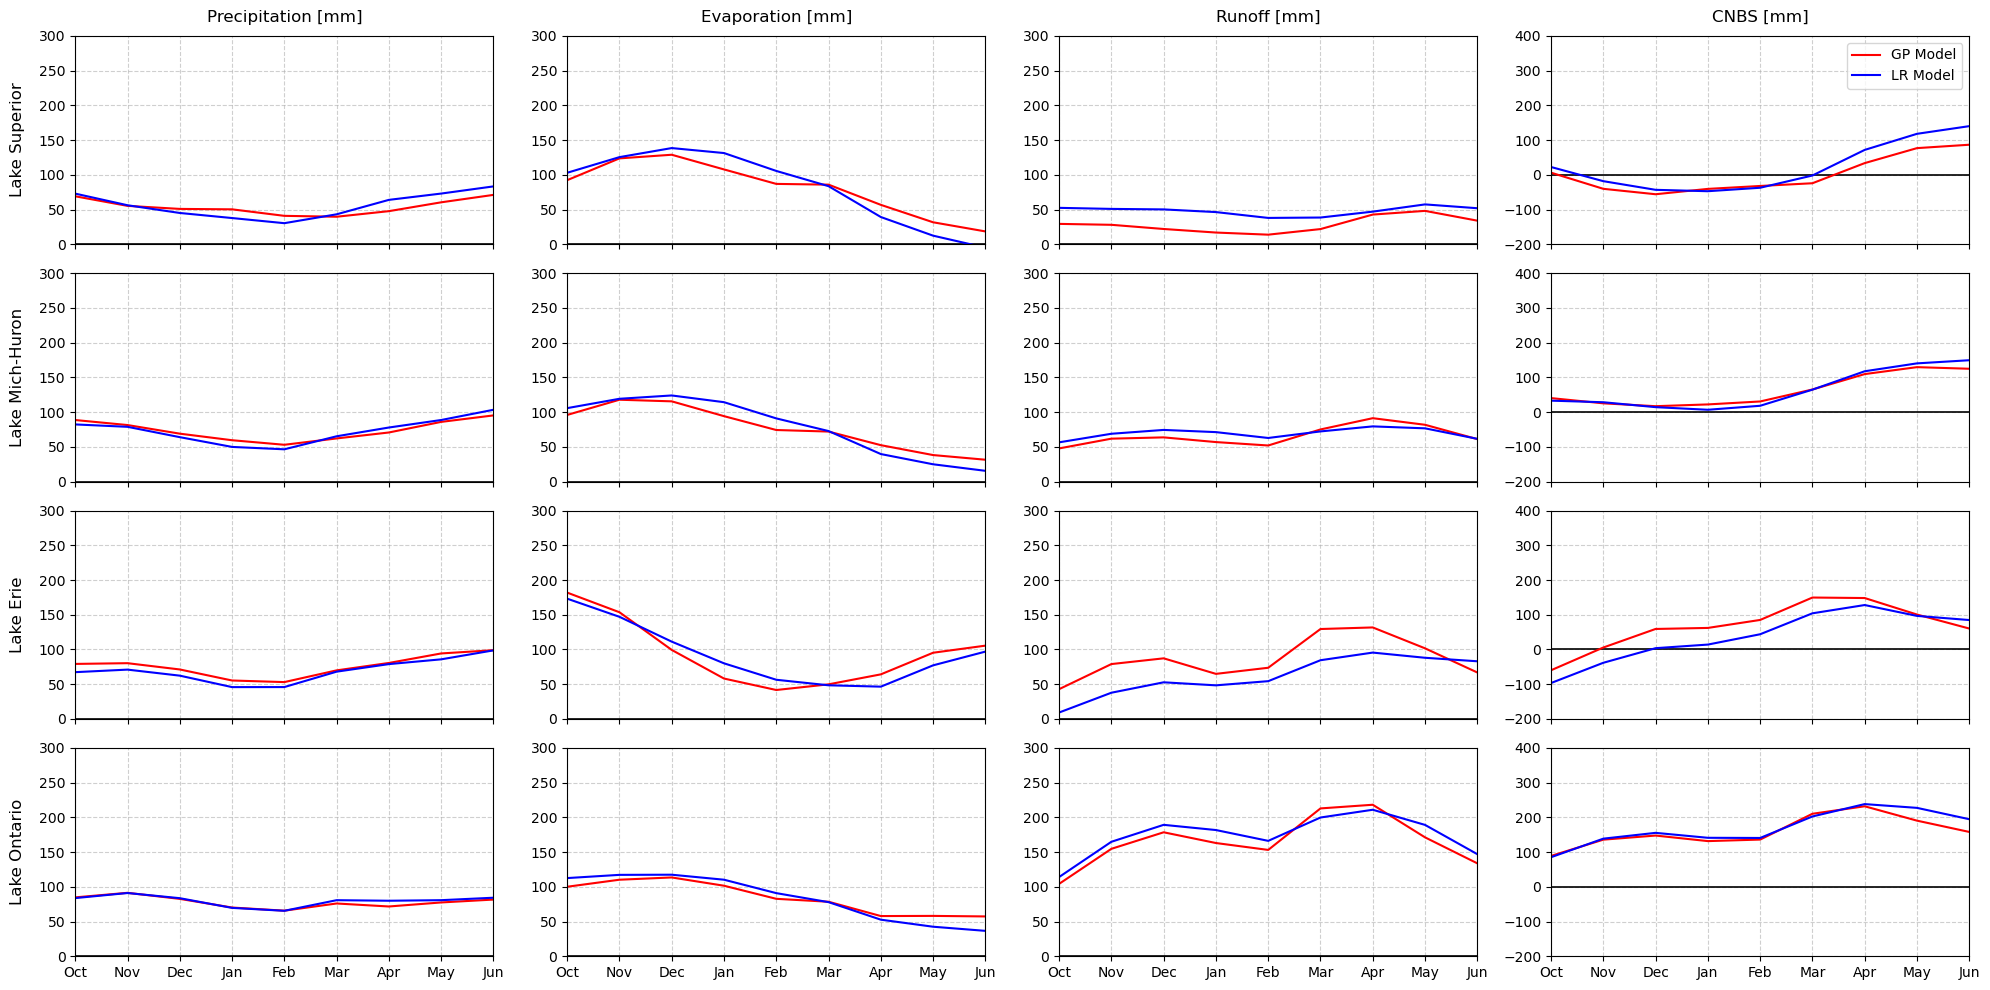

In [144]:
fig, axs = create_plot()

x_values = np.arange(len(mean_mh_cnbs))  # x-axis values

lake_data = [
    ('su_precip', 0), ('su_evap', 1), ('su_runoff', 2), ('su_cnbs', 3),
    ('mh_precip', 4), ('mh_evap', 5), ('mh_runoff', 6), ('mh_cnbs', 7),
    ('er_precip', 8), ('er_evap', 9), ('er_runoff', 10), ('er_cnbs', 11),
    ('on_precip', 12), ('on_evap', 13), ('on_runoff', 14), ('on_cnbs', 15)
]

# Loop through each lake data and plot
for lake_key, ax_index in lake_data:
    axs[ax_index].plot(x_values, results_gp[lake_key]['mean'], color='red', label='GP Model')

for lake_key, ax_index in lake_data:
    axs[ax_index].plot(x_values, results_lr[lake_key]['mean'], color='blue', label='LR Model')

axs[3].legend(loc='upper right')